Example file which shows some simple curve fitting using DARTSRegressor and some other estimators.

In [1]:
from functools import partial
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from autora.skl.darts import DARTSRegressor

In [2]:
# %% Define some helper functions

def show_results_complete(
    data_: pd.DataFrame,
    estimator=None,
    show_results=True,
    projection="2d",
    label=None,
):
    """
    Function to plot input data (x_, y_) and the predictions of an estimator for the same x_.
    """
    if projection == "2d":
        plt.figure()
        data_.plot.scatter(
            "S1", "S2", c="difference_detected", cmap="viridis", zorder=10
        )
    elif projection == "3d":
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.scatter(data_["S1"], data["S2"], data["difference_detected"])

        if estimator is not None:
            xs, ys = np.mgrid[0:5:0.2, 0:5:0.2]  # type: ignore

            zs = estimator.predict(np.column_stack((xs.ravel(), ys.ravel())))

            ax.plot_surface(xs, ys, zs.reshape(xs.shape), alpha=0.5)

    if label is not None:
        plt.title(label)

    if show_results:
        plt.show()

    return


In [3]:
datastr = """ID,S1,S2,difference_detected
0,0.0,0.0,0.5
1,0.0,0.2631578947368421,0.5654124021530151
2,0.0,0.5263157894736842,0.6286234259605408
3,0.0,0.7894736842105263,0.6877183318138123
4,0.0,1.0526315789473684,0.7412799000740051
5,0.0,1.3157894736842104,0.7884804010391235
6,0.0,1.5789473684210529,0.8290553689002991
7,0.0,1.8421052631578947,0.8631975054740906
8,0.0,2.1052631578947367,0.8914136290550232
9,0.0,2.3684210526315788,0.9143873453140259
10,0.0,2.631578947368421,0.9328665137290955
11,0.0,2.8947368421052633,0.9475856423377991
12,0.0,3.1578947368421053,0.9592186808586121
13,0.0,3.421052631578948,0.9683560729026794
14,0.0,3.684210526315789,0.975498378276825
15,0.0,3.947368421052632,0.9810601472854614
16,0.0,4.2105263157894735,0.9853783845901489
17,0.0,4.473684210526316,0.9887233972549438
18,0.0,4.7368421052631575,0.9913098812103271
19,0.0,5.0,0.9933071732521057
20,0.2631578947368421,0.2631578947368421,0.43458759784698486
21,0.2631578947368421,0.5263157894736842,0.5
22,0.2631578947368421,0.7894736842105263,0.5654124021530151
23,0.2631578947368421,1.0526315789473684,0.6286234259605408
24,0.2631578947368421,1.3157894736842104,0.6877183318138123
25,0.2631578947368421,1.5789473684210529,0.7412799000740051
26,0.2631578947368421,1.8421052631578947,0.7884804010391235
27,0.2631578947368421,2.1052631578947367,0.8290553689002991
28,0.2631578947368421,2.3684210526315788,0.8631975054740906
29,0.2631578947368421,2.631578947368421,0.8914136290550232
30,0.2631578947368421,2.8947368421052633,0.9143873453140259
31,0.2631578947368421,3.1578947368421053,0.9328665137290955
32,0.2631578947368421,3.421052631578948,0.9475856423377991
33,0.2631578947368421,3.684210526315789,0.9592186808586121
34,0.2631578947368421,3.947368421052632,0.9683560729026794
35,0.2631578947368421,4.2105263157894735,0.975498378276825
36,0.2631578947368421,4.473684210526316,0.9810601472854614
37,0.2631578947368421,4.7368421052631575,0.9853783845901489
38,0.2631578947368421,5.0,0.9887233972549438
39,0.5263157894736842,0.5263157894736842,0.37137657403945923
40,0.5263157894736842,0.7894736842105263,0.43458759784698486
41,0.5263157894736842,1.0526315789473684,0.5
42,0.5263157894736842,1.3157894736842104,0.5654124021530151
43,0.5263157894736842,1.5789473684210529,0.6286234259605408
44,0.5263157894736842,1.8421052631578947,0.6877183318138123
45,0.5263157894736842,2.1052631578947367,0.7412799000740051
46,0.5263157894736842,2.3684210526315788,0.7884804010391235
47,0.5263157894736842,2.631578947368421,0.8290553689002991
48,0.5263157894736842,2.8947368421052633,0.8631975054740906
49,0.5263157894736842,3.1578947368421053,0.8914136290550232
50,0.5263157894736842,3.421052631578948,0.9143873453140259
51,0.5263157894736842,3.684210526315789,0.9328665137290955
52,0.5263157894736842,3.947368421052632,0.9475856423377991
53,0.5263157894736842,4.2105263157894735,0.9592186808586121
54,0.5263157894736842,4.473684210526316,0.9683560729026794
55,0.5263157894736842,4.7368421052631575,0.975498378276825
56,0.5263157894736842,5.0,0.9810601472854614
57,0.7894736842105263,0.7894736842105263,0.31228166818618774
58,0.7894736842105263,1.0526315789473684,0.37137657403945923
59,0.7894736842105263,1.3157894736842104,0.43458759784698486
60,0.7894736842105263,1.5789473684210529,0.5
61,0.7894736842105263,1.8421052631578947,0.5654124021530151
62,0.7894736842105263,2.1052631578947367,0.6286234259605408
63,0.7894736842105263,2.3684210526315788,0.6877182722091675
64,0.7894736842105263,2.631578947368421,0.7412799000740051
65,0.7894736842105263,2.8947368421052633,0.788480281829834
66,0.7894736842105263,3.1578947368421053,0.8290553689002991
67,0.7894736842105263,3.421052631578948,0.8631974458694458
68,0.7894736842105263,3.684210526315789,0.8914136290550232
69,0.7894736842105263,3.947368421052632,0.9143873453140259
70,0.7894736842105263,4.2105263157894735,0.9328665137290955
71,0.7894736842105263,4.473684210526316,0.9475856423377991
72,0.7894736842105263,4.7368421052631575,0.9592186808586121
73,0.7894736842105263,5.0,0.9683560729026794
74,1.0526315789473684,1.0526315789473684,0.2587200701236725
75,1.0526315789473684,1.3157894736842104,0.31228166818618774
76,1.0526315789473684,1.5789473684210529,0.37137657403945923
77,1.0526315789473684,1.8421052631578947,0.43458759784698486
78,1.0526315789473684,2.1052631578947367,0.5
79,1.0526315789473684,2.3684210526315788,0.5654124021530151
80,1.0526315789473684,2.631578947368421,0.628623366355896
81,1.0526315789473684,2.8947368421052633,0.6877182722091675
82,1.0526315789473684,3.1578947368421053,0.7412799000740051
83,1.0526315789473684,3.421052631578948,0.7884804010391235
84,1.0526315789473684,3.684210526315789,0.8290553689002991
85,1.0526315789473684,3.947368421052632,0.8631974458694458
86,1.0526315789473684,4.2105263157894735,0.8914136290550232
87,1.0526315789473684,4.473684210526316,0.9143873453140259
88,1.0526315789473684,4.7368421052631575,0.9328665137290955
89,1.0526315789473684,5.0,0.9475856423377991
90,1.3157894736842104,1.3157894736842104,0.21151967346668243
91,1.3157894736842104,1.5789473684210529,0.2587200999259949
92,1.3157894736842104,1.8421052631578947,0.31228169798851013
93,1.3157894736842104,2.1052631578947367,0.3713766038417816
94,1.3157894736842104,2.3684210526315788,0.43458759784698486
95,1.3157894736842104,2.631578947368421,0.5
96,1.3157894736842104,2.8947368421052633,0.5654124021530151
97,1.3157894736842104,3.1578947368421053,0.6286234855651855
98,1.3157894736842104,3.421052631578948,0.6877183318138123
99,1.3157894736842104,3.684210526315789,0.7412799000740051
100,1.3157894736842104,3.947368421052632,0.7884804010391235
101,1.3157894736842104,4.2105263157894735,0.8290553689002991
102,1.3157894736842104,4.473684210526316,0.8631975054740906
103,1.3157894736842104,4.7368421052631575,0.8914136290550232
104,1.3157894736842104,5.0,0.9143873453140259
105,1.5789473684210529,1.5789473684210529,0.17094460129737854
106,1.5789473684210529,1.8421052631578947,0.21151965856552124
107,1.5789473684210529,2.1052631578947367,0.2587200701236725
108,1.5789473684210529,2.3684210526315788,0.31228166818618774
109,1.5789473684210529,2.631578947368421,0.37137654423713684
110,1.5789473684210529,2.8947368421052633,0.4345875084400177
111,1.5789473684210529,3.1578947368421053,0.5
112,1.5789473684210529,3.421052631578948,0.5654124021530151
113,1.5789473684210529,3.684210526315789,0.6286234259605408
114,1.5789473684210529,3.947368421052632,0.6877183318138123
115,1.5789473684210529,4.2105263157894735,0.7412799000740051
116,1.5789473684210529,4.473684210526316,0.788480281829834
117,1.5789473684210529,4.7368421052631575,0.8290553689002991
118,1.5789473684210529,5.0,0.8631974458694458
119,1.8421052631578947,1.8421052631578947,0.13680249452590942
120,1.8421052631578947,2.1052631578947367,0.17094461619853973
121,1.8421052631578947,2.3684210526315788,0.21151967346668243
122,1.8421052631578947,2.631578947368421,0.2587200701236725
123,1.8421052631578947,2.8947368421052633,0.31228166818618774
124,1.8421052631578947,3.1578947368421053,0.3713766038417816
125,1.8421052631578947,3.421052631578948,0.43458759784698486
126,1.8421052631578947,3.684210526315789,0.5
127,1.8421052631578947,3.947368421052632,0.5654124021530151
128,1.8421052631578947,4.2105263157894735,0.6286234259605408
129,1.8421052631578947,4.473684210526316,0.6877183318138123
130,1.8421052631578947,4.7368421052631575,0.7412799000740051
131,1.8421052631578947,5.0,0.788480281829834
132,2.1052631578947367,2.1052631578947367,0.10858631134033203
133,2.1052631578947367,2.3684210526315788,0.13680247962474823
134,2.1052631578947367,2.631578947368421,0.17094458639621735
135,2.1052631578947367,2.8947368421052633,0.21151962876319885
136,2.1052631578947367,3.1578947368421053,0.2587200701236725
137,2.1052631578947367,3.421052631578948,0.31228166818618774
138,2.1052631578947367,3.684210526315789,0.37137654423713684
139,2.1052631578947367,3.947368421052632,0.4345875084400177
140,2.1052631578947367,4.2105263157894735,0.5
141,2.1052631578947367,4.473684210526316,0.5654124021530151
142,2.1052631578947367,4.7368421052631575,0.628623366355896
143,2.1052631578947367,5.0,0.6877182722091675
144,2.3684210526315788,2.3684210526315788,0.08561266213655472
145,2.3684210526315788,2.631578947368421,0.10858631134033203
146,2.3684210526315788,2.8947368421052633,0.13680247962474823
147,2.3684210526315788,3.1578947368421053,0.17094461619853973
148,2.3684210526315788,3.421052631578948,0.21151967346668243
149,2.3684210526315788,3.684210526315789,0.2587200701236725
150,2.3684210526315788,3.947368421052632,0.31228166818618774
151,2.3684210526315788,4.2105263157894735,0.3713766038417816
152,2.3684210526315788,4.473684210526316,0.43458759784698486
153,2.3684210526315788,4.7368421052631575,0.5
154,2.3684210526315788,5.0,0.5654124021530151
155,2.631578947368421,2.631578947368421,0.06713350117206573
156,2.631578947368421,2.8947368421052633,0.08561266213655472
157,2.631578947368421,3.1578947368421053,0.10858633369207382
158,2.631578947368421,3.421052631578948,0.13680250942707062
159,2.631578947368421,3.684210526315789,0.17094461619853973
160,2.631578947368421,3.947368421052632,0.21151967346668243
161,2.631578947368421,4.2105263157894735,0.25872012972831726
162,2.631578947368421,4.473684210526316,0.3122817277908325
163,2.631578947368421,4.7368421052631575,0.3713766038417816
164,2.631578947368421,5.0,0.43458759784698486
165,2.8947368421052633,2.8947368421052633,0.052414361387491226
166,2.8947368421052633,3.1578947368421053,0.06713351607322693
167,2.8947368421052633,3.421052631578948,0.08561268448829651
168,2.8947368421052633,3.684210526315789,0.10858633369207382
169,2.8947368421052633,3.947368421052632,0.13680250942707062
170,2.8947368421052633,4.2105263157894735,0.17094466090202332
171,2.8947368421052633,4.473684210526316,0.21151971817016602
172,2.8947368421052633,4.7368421052631575,0.25872012972831726
173,2.8947368421052633,5.0,0.3122817277908325
174,3.1578947368421053,3.1578947368421053,0.04078132286667824
175,3.1578947368421053,3.421052631578948,0.052414342761039734
176,3.1578947368421053,3.684210526315789,0.06713348627090454
177,3.1578947368421053,3.947368421052632,0.08561263978481293
178,3.1578947368421053,4.2105263157894735,0.10858631134033203
179,3.1578947368421053,4.473684210526316,0.13680247962474823
180,3.1578947368421053,4.7368421052631575,0.17094458639621735
181,3.1578947368421053,5.0,0.21151962876319885
182,3.421052631578948,3.421052631578948,0.031643956899642944
183,3.421052631578948,3.684210526315789,0.04078132286667824
184,3.421052631578948,3.947368421052632,0.052414342761039734
185,3.421052631578948,4.2105263157894735,0.06713350117206573
186,3.421052631578948,4.473684210526316,0.08561266213655472
187,3.421052631578948,4.7368421052631575,0.10858631134033203
188,3.421052631578948,5.0,0.13680247962474823
189,3.684210526315789,3.684210526315789,0.024501590058207512
190,3.684210526315789,3.947368421052632,0.031643956899642944
191,3.684210526315789,4.2105263157894735,0.04078133404254913
192,3.684210526315789,4.473684210526316,0.052414361387491226
193,3.684210526315789,4.7368421052631575,0.06713350117206573
194,3.684210526315789,5.0,0.08561266213655472
195,3.947368421052632,3.947368421052632,0.018939798697829247
196,3.947368421052632,4.2105263157894735,0.02450159564614296
197,3.947368421052632,4.473684210526316,0.03164396435022354
198,3.947368421052632,4.7368421052631575,0.04078133404254913
199,3.947368421052632,5.0,0.052414361387491226
200,4.2105263157894735,4.2105263157894735,0.01462159026414156
201,4.2105263157894735,4.473684210526316,0.0189397931098938
202,4.2105263157894735,4.7368421052631575,0.024501584470272064
203,4.2105263157894735,5.0,0.03164394944906235
204,4.473684210526316,4.473684210526316,0.011276605539023876
205,4.473684210526316,4.7368421052631575,0.01462159026414156
206,4.473684210526316,5.0,0.0189397931098938
207,4.7368421052631575,4.7368421052631575,0.008690104819834232
208,4.7368421052631575,5.0,0.011276605539023876
209,5.0,5.0,0.006692850962281227
"""

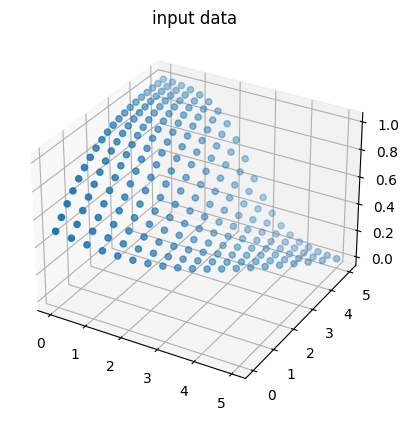

In [4]:
# %% Load the data
data = pd.read_csv(StringIO(datastr))
show_results = partial(show_results_complete, data_=data, projection="3d")
show_results(label="input data")

X = data[["S1", "S2"]]
y = data["difference_detected"]

/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-17yK3Jyq-py3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


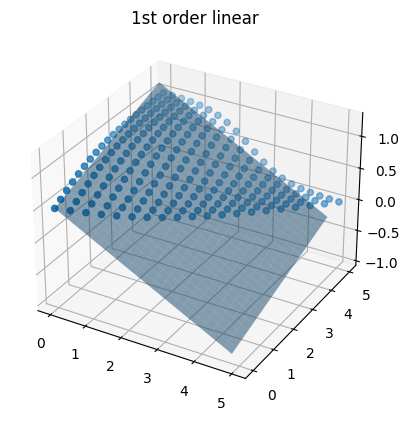

In [5]:
# %% Fit first using a super-simple linear regression

first_order_linear_estimator = LinearRegression()
first_order_linear_estimator.fit(X, y)

show_results(estimator=first_order_linear_estimator, label="1st order linear")

/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-17yK3Jyq-py3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


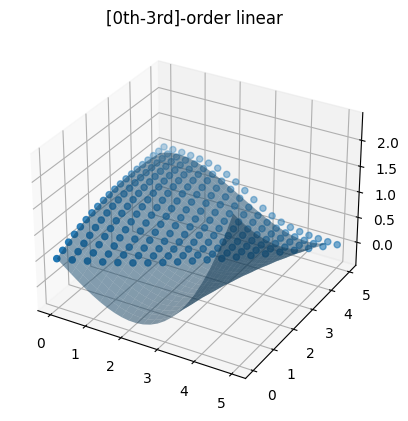

In [6]:
# %% Fit using a 0-3 order polynomial, getting the best fit for the data.
polynomial_estimator = GridSearchCV(
    make_pipeline(PolynomialFeatures(), LinearRegression(fit_intercept=False)),
    param_grid=dict(polynomialfeatures__degree=range(4)),
)
polynomial_estimator.fit(X, y)

show_results(estimator=polynomial_estimator, label="[0th-3rd]-order linear")

  0%|          | 0/30 [00:00<?, ?it/s]

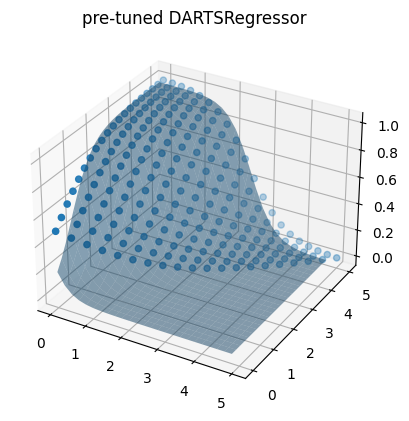

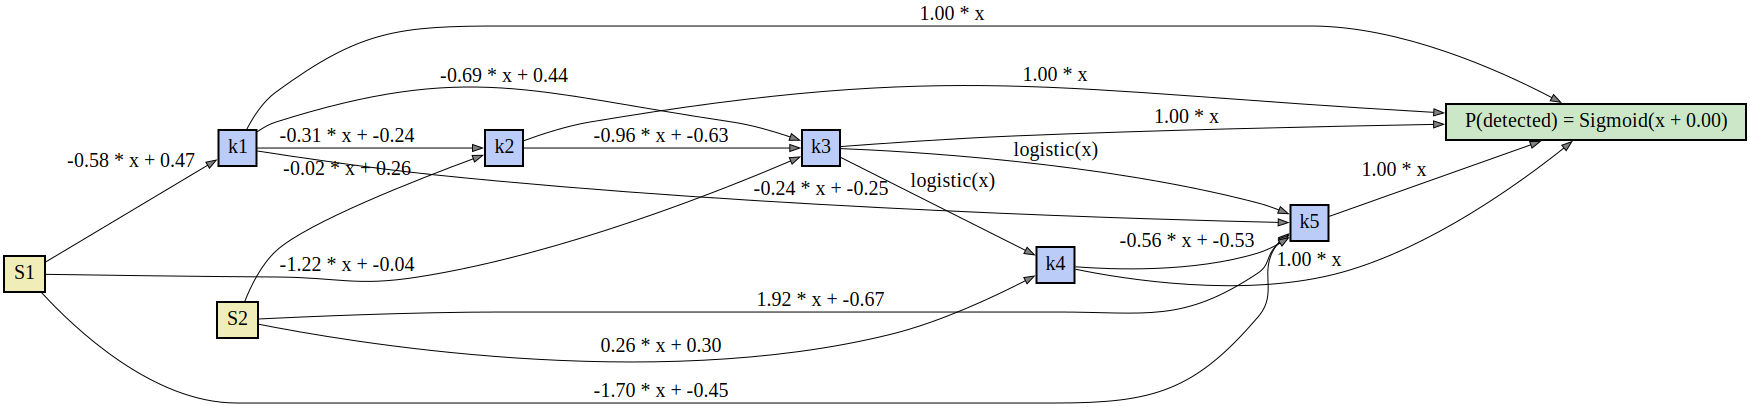

In [7]:
darts_estimator_tuned = DARTSRegressor(
    batch_size=64,
    arch_updates_per_epoch=100,
    param_updates_per_epoch=100,
    max_epochs=30,
    output_type="probability",
    num_graph_nodes=5,
    primitives=[
        "none",
        "linear",
        "logistic",
        ]
)

darts_estimator_tuned.fit(X, y)

show_results(estimator=darts_estimator_tuned, label="pre-tuned DARTSRegressor")
darts_estimator_tuned.visualize_model()

  0%|          | 0/1 [00:00<?, ?it/s]

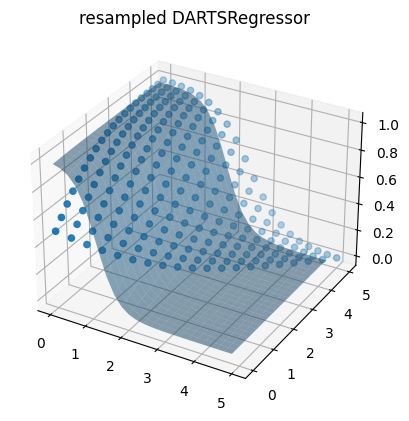

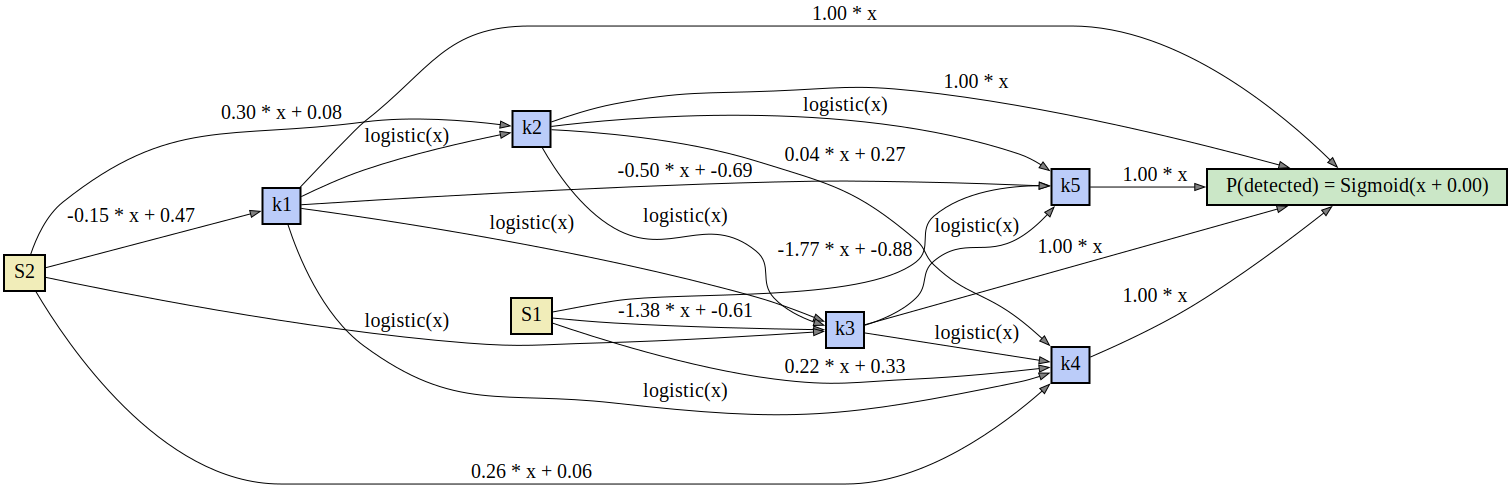

In [8]:
darts_estimator_tuned.set_params(
    arch_updates_per_epoch=0,
    param_updates_per_epoch=1000,
    sampling_strategy="sample",
    max_epochs=1
)
darts_estimator_tuned.fit(X, y)
show_results(estimator=darts_estimator_tuned, label="resampled DARTSRegressor")
darts_estimator_tuned.visualize_model()


0it [00:00, ?it/s]

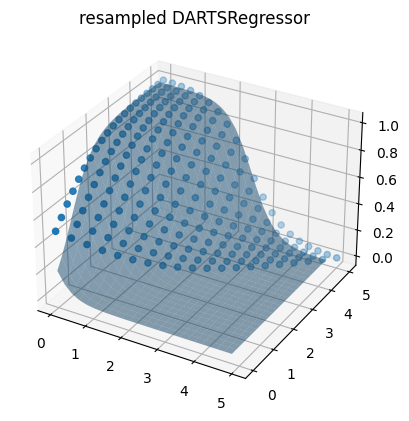

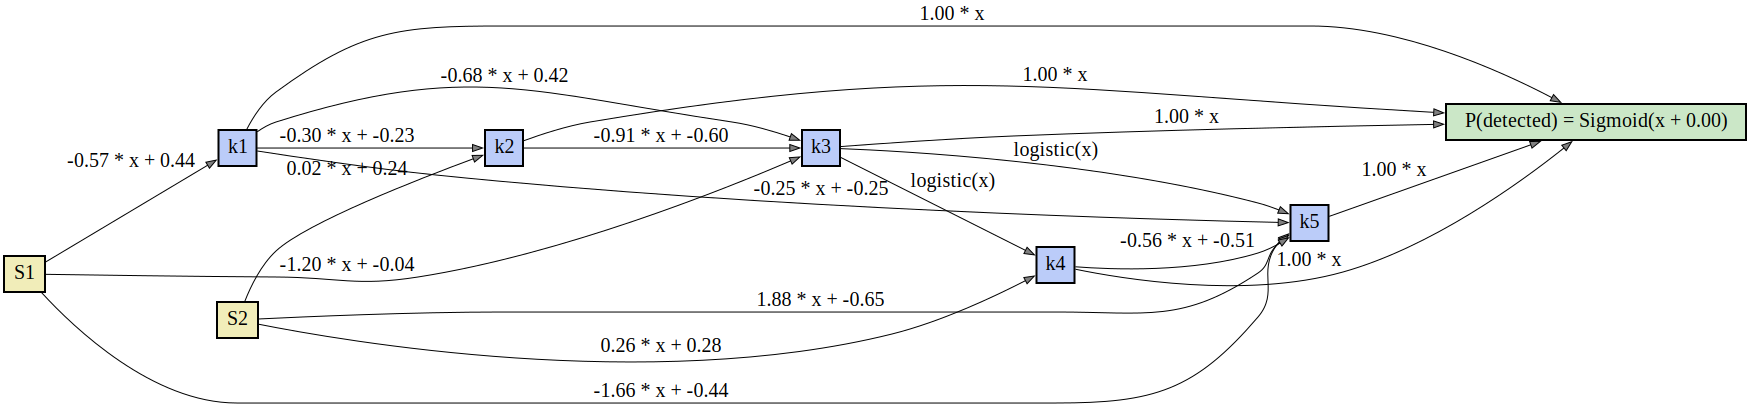

In [9]:
darts_estimator_tuned.set_params(
    arch_updates_per_epoch=0,
    param_updates_per_epoch=1000,
    sampling_strategy="max",
    max_epochs=0
)
darts_estimator_tuned.fit(X, y)
show_results(estimator=darts_estimator_tuned, label="resampled DARTSRegressor")
darts_estimator_tuned.visualize_model()
